In [1]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
from argparse import Namespace
import matplotlib.pyplot as plt
import os
import json

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import tqdm

In [3]:
class ElmanRNN(nn.Module):
  def __init__(self, input_size, hidden_size, batch_first=False):
    #batch_first --> batch가 0번째 차원이면 True
    super(ElmanRNN, self).__init__()
    self.rnn_cell = nn.RNNCell(input_size, hidden_size)

    self.batch_first = batch_first
    self.hidden_size = hidden_size

  def initialize_hidden(self, batch_size):
    return torch.zeros((batch_size, self.hidden_size))

  def forward(self, x_in, initial_hidden=None):

    if self.batch_first:
      #seq_size를 가장 앞으로 당김.
      batch_size, seq_size, feat_size = x_in.size()
      x_in = x_in.permute(1, 0, 2)
    else:
      seq_size, batch_size, feat_size = x_in.size()

    hiddens = []

    if initial_hidden is None:
      initial_hidden = self.initialize_hidden(batch_size)
      initial_hidden = initial_hidden.to(x_in.device)

    hidden_t = initial_hidden

    for t in range(seq_size):
      hidden_t = self.rnn_cell(x_in[t], hidden_t)
      hiddens.append(hidden_t)

    hiddens = torch.stack(hiddens)

    if self.batch_first:
      hiddens = hiddens.permute(1, 0, 2)

    return hiddens

"""ELMAN RNN의 입력의 형태
- batch_fisrt=True 기준

x_in.shape[0] = batch_size
x_in.shape[1] = max_sequence_length
x_in.shape[2] = embedding_dimension(feat_size)

[
  [
    [.1 .2 .4 ... .6], #<SOS>
    [.1 .3 .5 ... .8], #token1
    ...,
    [.2 .3 .4 ... .6], #<EOS>
  ],
  [
    [.1 .2 .4 ... .6], #<SOS>
    [.1 .3 .5 ... .8], #token1
    ...,
    [.2 .3 .4 ... .6], #<EOS>
    [.2 .3 .4 ... .6], #<MASK>
    ...,
    [.2 .3 .4 ... .6], #<MASK>
  ], #max_seq_legnth가 모자라는 경우 <MASK> token이 들어감.
  ...
  [
    [.1 .2 .4 ... .6], #<SOS>
    [.1 .3 .5 ... .8], #token1
    ...,
    [.2 .3 .4 ... .6], #<EOS>
  ],
] -> type = torch.FloatTensor
"""

'ELMAN RNN의 입력의 형태\n- batch_fisrt=True 기준\n\nx_in.shape[0] = batch_size\nx_in.shape[1] = max_sequence_length\nx_in.shape[2] = embedding_dimension(feat_size)\n\n[\n  [\n    [.1 .2 .4 ... .6], #<SOS>\n    [.1 .3 .5 ... .8], #token1\n    ...,\n    [.2 .3 .4 ... .6], #<EOS>\n  ],\n  [\n    [.1 .2 .4 ... .6], #<SOS>\n    [.1 .3 .5 ... .8], #token1\n    ...,\n    [.2 .3 .4 ... .6], #<EOS>\n    [.2 .3 .4 ... .6], #<MASK>\n    ...,\n    [.2 .3 .4 ... .6], #<MASK>\n  ], #max_seq_legnth가 모자라는 경우 <MASK> token이 들어감.\n  ...\n  [\n    [.1 .2 .4 ... .6], #<SOS>\n    [.1 .3 .5 ... .8], #token1\n    ...,\n    [.2 .3 .4 ... .6], #<EOS>\n  ],\n] -> type = torch.FloatTensor\n'

In [4]:
def column_gather(y_out, x_lengths):
  #길이를 index로 바꿈 -> -1
  #detach를 이용해 hidden_state의 깊은복사를 수행 -> gradient가 추적되지 않음.
  x_lengths = x_lengths.long().detach().cpu().numpy() - 1
  out = []
  for batch_index, column_index in enumerate(x_lengths):
    #3차원 행렬 y_out에서 batch_index번째 예측값의 column_index번째 hidden_vector를 가져옴.
    out.append(y_out[batch_index, column_index])
  return torch.stack(out)

In [5]:
class SurnameClassifier(nn.Module):
  def __init__(self, embedding_size, num_embeddings, num_classes,
               rnn_hidden_size, batch_first = True, padding_idx=0):
    super(SurnameClassifier, self).__init__()

    self.emb = nn.Embedding(num_embeddings=num_embeddings,
                          embedding_dim=embedding_size,
                          padding_idx=padding_idx)
    self.rnn = ElmanRNN(input_size=embedding_size,
                        hidden_size=rnn_hidden_size,
                        batch_first=batch_first)
    self.fc1 = nn.Linear(in_features=rnn_hidden_size,
                         out_features=rnn_hidden_size)
    self.fc2 = nn.Linear(in_features=rnn_hidden_size,
                         out_features=num_classes)

  def forward(self, x_in, x_lengths=None, apply_softmax=False):
    x_embedded = self.emb(x_in) #(batch_size, seq_size, embedding_size)
    y_out = self.rnn(x_embedded) #(batch_size, seq_size, hidden_size)

    if x_lengths is not None:
      y_out = column_gather(y_out, x_lengths)
    else:
      #단순히 -1을하면 가변길이 sequence에 대한 hidden vector를 바로 얻지 못함.
      y_out = y_out[:, -1, :] #출력: 마지막 hidden_state -> (batch_size, hidden_size)

    y_out = F.dropout(y_out, 0.5)
    y_out = F.relu(self.fc1(y_out)) # (batch_size, hidden_size)
    y_out = F.dropout(y_out, 0.5)
    y_out = self.fc2(y_out) # (batch_size, num_classes)

    if apply_softmax:
      y_out = F.softmax(y_out,  dim=1)

    return y_out # (batch_size, num_classes)

In [6]:
class SurnameDataset(Dataset):
  def __init__(self, surname_df, vectorizer):
    self.surname_df = surname_df
    self._vectorizer = vectorizer

    self._max_seq_length = max(map(len, self.surname_df.surname)) + 2

    self.train_df = self.surname_df[self.surname_df.split == "train"]
    self.train_size = len(self.train_df)

    self.val_df = self.surname_df[self.surname_df.split == "val"]
    self.validation_size = len(self.val_df)

    self.test_df = self.surname_df[self.surname_df.split == "test"]
    self.test_size = len(self.test_df)

    self._lookup_dict = {
        "train": (self.train_df, self.train_size),
        "val": (self.val_df, self.validation_size),
        "test": (self.test_df, self.test_size)
    }
    self.set_split("train")
    class_counts = self.train_df.nationality.value_counts().to_dict()
    def sort_key(item):
      return self._vectorizer.nationality_vocab.lookup_token(item[0])
    sorted_counts = sorted(class_counts.items(), key=sort_key)
    frequencies = [count for _, count in sorted_counts]
    self.class_weights = 1.0 / torch.tensor(frequencies, dtype=torch.int32)


  @classmethod
  def load_dataset_and_make_vectorizer(cls, surname_csv):
    surname_df = pd.read_csv(surname_csv)
    train_surname_df = surname_df[surname_df.split == "train"]
    return cls(surname_df, SurnameVectorizer.from_dataframe(train_surname_df))

  @classmethod
  def load_dataset_and_load_vectorizer(cls, surname_csv, vectorizer_filepath):
    surname_df = pd.read_csv(surname_csv)
    vectorizer = cls.load_vectorizer_only(vectorizer_filepath)
    return cls(surname_df, vectorizer)

  @staticmethod
  def load_vectorizer_only(vectorizer_filepath):
    with open(vectorizer_filepath) as fp:
      return SurnameVectorizer.from_serializable(json.load(fp))

  def save_vectorizer(self, vectorizer_filepath):
    with open(vectorizer_filepath, "w") as fp:
      json.dump(self._vectorizer.to_serializable(), fp)

  def get_vectorizer(self):
    return self._vectorizer

  def __getitem__(self, index):
    row = self._target_df.iloc[index]

    surname_vector, vec_length = \
      self._vectorizer.vectorize(row.surname, self._max_seq_length)

    nationality_index = \
    self._vectorizer.nationality_vocab.lookup_token(row.nationality)

    return {
        "x_data": surname_vector,
        "y_target": nationality_index,
        "x_length": vec_length
    }

  def set_split(self, split="train"):
    self._target_split = split
    self._target_df, self._target_size = self._lookup_dict[split]

  def __len__(self):
    return self._target_size

  def get_num_batches(self, batch_size):
    return len(self) // batch_size

def generate_batches(dataset, batch_size, shuffle=True,
                     drop_last=True, device="cpu"):
  dataloader = DataLoader(dataset=dataset, batch_size=batch_size,
                          shuffle=shuffle, drop_last=drop_last)

  for data_dict in dataloader:
    out_data_dict = {}
    for name, tensor in data_dict.items():
      out_data_dict[name] = data_dict[name].to(device)
    yield out_data_dict

In [7]:
class Vocabulary():
  def __init__(self, token_to_idx=None):
    if token_to_idx is None:
      token_to_idx = {}
    self._token_to_idx = token_to_idx
    self._idx_to_token = {idx:token for token, idx in self._token_to_idx.items()}

  def to_serializable(self):
    return {"token_to_idx": self._token_to_idx}

  @classmethod
  def from_serializable(cls, contents):
    return cls(**contents)

  def add_token(self, token):
    if token in self._token_to_idx:
      index = self._token_to_idx[token]
    else:
      index = len(self._token_to_idx)
      self._token_to_idx[token] = index
      self._idx_to_token[index] = token
    return index

  def add_many(self, tokens):
    return [self.add_token(token) for token in tokens]

  def lookup_token(self,token):
    return self._token_to_idx[token]

  def lookup_index(self, index):
    if index not in self._idx_to_token:
      raise KeyError("the index (%d) is not in the Vocabulary" % index)
    return self._idx_to_token[index]

  def __str__(self):
    return "<Vocabulary(size=%d)>" % len(self)

  def __len__(self):
    return len(self._token_to_idx)

In [8]:
class SequenceVocabulary(Vocabulary): #상속
  def __init__(self, token_to_idx= None, unk_token="<UNK>",
               mask_token="<MASK>", begin_seq_token="<BEGIN>",
               end_seq_token="<END>"):
    super(SequenceVocabulary, self).__init__(token_to_idx)

    self._mask_token = mask_token
    self._unk_token = unk_token
    self._begin_seq_token = begin_seq_token
    self._end_seq_token = end_seq_token

    self.mask_index = self.add_token(self._mask_token)
    self.unk_index = self.add_token(self._unk_token)
    self.begin_seq_index = self.add_token(self._begin_seq_token)
    self.end_seq_index = self.add_token(self._end_seq_token)

  def to_serializable(self):
    contents = super(SequenceVocabulary, self).to_serializable()
    contents.update(
        {
            "unk_token": self._unk_token,
            "mask_token": self._mask_token,
            "begin_seq_token": self._begin_seq_token,
            "end_seq_token": self._end_seq_token
        }
    )
    return contents

  def lookup_token(self, token):
    if self.unk_index >= 0:
      return self._token_to_idx.get(token, self.unk_index)
    else:
      return self._token_to_idx[token]

In [37]:
class SurnameVectorizer():
  def __init__(self, char_vocab, nationality_vocab):
    self.char_vocab = char_vocab
    self.nationality_vocab = nationality_vocab

  def vectorize(self, surname, vector_length=-1):
    indices = [self.char_vocab.begin_seq_index]
    indices += [self.char_vocab.lookup_token(token) for token in surname]
    indices += [self.char_vocab.end_seq_index]

    if vector_length < 0:
      vector_length = len(indices)

    out_vector = np.zeros(vector_length, dtype=np.int64)
    out_vector[:len(indices)] = indices
    out_vector[len(indices):] = self.char_vocab.mask_index

    return out_vector, len(indices)

  @classmethod
  def from_dataframe(cls, surname_df):
    char_vocab = SequenceVocabulary()
    nationality_vocab = Vocabulary()

    for index, row, in surname_df.iterrows():
      for char in row.surname:
        char_vocab.add_token(char)
      nationality_vocab.add_token(row.nationality)
    return cls(char_vocab, nationality_vocab)

  @classmethod
  def from_serializable(cls, contents):
    char_vocab = SequenceVocabulary.from_serializable(contents["char_vocab"])
    nat_vocab = Vocabulary.from_serializable(contents["nationality_vocab"])

    return cls(char_vocab=char_vocab, nationality_vocab=nat_vocab)

  def to_serializable(self):
    return {
        "char_vocab": self.char_vocab.to_serializable(),
        "nationality_vocab": self.nationality_vocab.to_serializable()
    }

In [10]:
base_path = "/content/drive/MyDrive/Github_NLP/NLP_with_PyTorch/Chapter6_Seq_Modeling_Novice/"

In [11]:
def set_seed_everywhere(seed, cuda):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if cuda:


        torch.cuda.manual_seed_all(seed)

def handle_dirs(dirpath):
    if not os.path.exists(dirpath):
        os.makedirs(dirpath)

In [12]:
args = Namespace(
    # 날짜와 경로 정보
    surname_csv=base_path + "data/surnames/surnames_with_splits.csv",
    vectorizer_file="vectorizer.json",
    model_state_file="model.pth",
    save_dir=base_path + "model_storage/ch6/surname_classification",
    # 모델 하이퍼파라미터
    char_embedding_size=100,
    rnn_hidden_size=64,
    # 훈련 하이퍼파라미터
    num_epochs=100,
    learning_rate=1e-3,
    batch_size=64,
    seed=1337,
    early_stopping_criteria=5,
    # 실행 옵션
    cuda=True,
    catch_keyboard_interrupt=True,
    reload_from_files=False,
    expand_filepaths_to_save_dir=True,
)

# CUDA 체크
if not torch.cuda.is_available():
    args.cuda = False

args.device = torch.device("cuda" if args.cuda else "cpu")

print("CUDA 사용여부: {}".format(args.cuda))


if args.expand_filepaths_to_save_dir:
    import os
    args.vectorizer_file = os.path.join(args.save_dir,
                                        args.vectorizer_file)

    args.model_state_file = os.path.join(args.save_dir,
                                         args.model_state_file)

# 재현성을 위해 시드 설정
set_seed_everywhere(args.seed, args.cuda)

# 디렉토리 처리
handle_dirs(args.save_dir)
print(args.surname_csv)
print(args.vectorizer_file)
print(args.model_state_file)

CUDA 사용여부: True
/content/drive/MyDrive/Github_NLP/NLP_with_PyTorch/Chapter6_Seq_Modeling_Novice/data/surnames/surnames_with_splits.csv
/content/drive/MyDrive/Github_NLP/NLP_with_PyTorch/Chapter6_Seq_Modeling_Novice/model_storage/ch6/surname_classification/vectorizer.json
/content/drive/MyDrive/Github_NLP/NLP_with_PyTorch/Chapter6_Seq_Modeling_Novice/model_storage/ch6/surname_classification/model.pth


In [13]:
# 만약 코랩에서 실행하는 경우 아래 코드를 실행하여 전처리된 데이터를 다운로드하세요.
!mkdir /content/drive/MyDrive/Github_NLP/NLP_with_PyTorch/Chapter6_Seq_Modeling_Novice/data
!wget https://git.io/JtSPf -O /content/drive/MyDrive/Github_NLP/NLP_with_PyTorch/Chapter6_Seq_Modeling_Novice/data/download.py
!wget https://git.io/JtSPU -O /content/drive/MyDrive/Github_NLP/NLP_with_PyTorch/Chapter6_Seq_Modeling_Novice/data/get-all-data.sh
!chmod 755 /content/drive/MyDrive/Github_NLP/NLP_with_PyTorch/Chapter6_Seq_Modeling_Novice/data/get-all-data.sh
%cd /content/drive/MyDrive/Github_NLP/NLP_with_PyTorch/Chapter6_Seq_Modeling_Novice/data
!./get-all-data.sh
%cd ..

mkdir: cannot create directory ‘/content/drive/MyDrive/Github_NLP/NLP_with_PyTorch/Chapter6_Seq_Modeling_Novice/data’: File exists
--2024-03-17 08:39:04--  https://git.io/JtSPf
Resolving git.io (git.io)... 140.82.113.22
Connecting to git.io (git.io)|140.82.113.22|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://raw.githubusercontent.com/rickiepark/nlp-with-pytorch/main/chapter_6/classifying-surnames/data/download.py [following]
--2024-03-17 08:39:04--  https://raw.githubusercontent.com/rickiepark/nlp-with-pytorch/main/chapter_6/classifying-surnames/data/download.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1572 (1.5K) [text/plain]
Saving to: ‘/content/drive/MyDrive/Github_NLP/NLP_with_PyTorch/Chapter6_S

In [38]:
if args.reload_from_files and os.path.exists(args.vectorizer_file):
    # 체크포인트를 로드합니다.
    dataset = SurnameDataset.load_dataset_and_load_vectorizer(args.surname_csv,
                                                              args.vectorizer_file)
else:
    # 데이터셋과 Vectorizer를 만듭니다.
    dataset = SurnameDataset.load_dataset_and_make_vectorizer(args.surname_csv)
    dataset.save_vectorizer(args.vectorizer_file)

vectorizer = dataset.get_vectorizer()

classifier = SurnameClassifier(embedding_size=args.char_embedding_size,
                               num_embeddings=len(vectorizer.char_vocab),
                               num_classes=len(vectorizer.nationality_vocab),
                               rnn_hidden_size=args.rnn_hidden_size,
                               padding_idx=vectorizer.char_vocab.mask_index)

In [39]:
def make_train_state(args):
    return {'stop_early': False,
            'early_stopping_step': 0,
            'early_stopping_best_val': 1e8,
            'learning_rate': args.learning_rate,
            'epoch_index': 0,
            'train_loss': [],
            'train_acc': [],
            'val_loss': [],
            'val_acc': [],
            'test_loss': -1,
            'test_acc': -1,
            'model_filename': args.model_state_file}


def update_train_state(args, model, train_state):
    """훈련 상태를 업데이트합니다.

    콤포넌트:
     - 조기 종료: 과대 적합 방지
     - 모델 체크포인트: 더 나은 모델을 저장합니다

    :param args: 메인 매개변수
    :param model: 훈련할 모델
    :param train_state: 훈련 상태를 담은 딕셔너리
    :returns:
        새로운 훈련 상태
    """

    # 적어도 한 번 모델을 저장합니다
    if train_state['epoch_index'] == 0:
        torch.save(model.state_dict(), train_state['model_filename'])
        train_state['stop_early'] = False

    # 성능이 향상되면 모델을 저장합니다
    elif train_state['epoch_index'] >= 1:
        loss_tm1, loss_t = train_state['val_loss'][-2:]

        # 손실이 나빠지면
        if loss_t >= train_state["early_stopping_best_val"]:
            # 조기 종료 단계 업데이트
            train_state['early_stopping_step'] += 1
        # 손실이 감소하면
        else:
            # 최상의 모델 저장
            if loss_t < train_state['early_stopping_best_val']:
                torch.save(model.state_dict(), train_state['model_filename'])
                train_state['early_stopping_best_val'] = loss_t

            # 조기 종료 단계 재설정
            train_state['early_stopping_step'] = 0

        # 조기 종료 여부 확인
        train_state['stop_early'] = \
            train_state['early_stopping_step'] >= args.early_stopping_criteria

    return train_state


def compute_accuracy(y_pred, y_target):
    _, y_pred_indices = y_pred.max(dim=1)
    n_correct = torch.eq(y_pred_indices, y_target).sum().item()
    return n_correct / len(y_pred_indices) * 100

In [40]:
classifier = classifier.to(args.device)
dataset.class_weights = dataset.class_weights.to(args.device)

loss_func = nn.CrossEntropyLoss(dataset.class_weights)
optimizer = optim.Adam(classifier.parameters(), lr=args.learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                           mode='min', factor=0.5,
                                           patience=1)

train_state = make_train_state(args)

epoch_bar = tqdm.notebook.tqdm(desc='training routine',
                               total=args.num_epochs,
                               position=0)

dataset.set_split('train')
train_bar = tqdm.notebook.tqdm(desc='split=train',
                               total=dataset.get_num_batches(args.batch_size),
                               position=1,
                               leave=True)
dataset.set_split('val')
val_bar = tqdm.notebook.tqdm(desc='split=val',
                             total=dataset.get_num_batches(args.batch_size),
                             position=1,
                             leave=True)

try:
    for epoch_index in range(args.num_epochs):
        train_state['epoch_index'] = epoch_index

        # 훈련 세트에 대한 순회

        # 훈련 세트와 배치 제너레이터 준비, 손실과 정확도를 0으로 설정
        dataset.set_split('train')
        batch_generator = generate_batches(dataset,
                                           batch_size=args.batch_size,
                                           device=args.device)
        running_loss = 0.0
        running_acc = 0.0
        classifier.train()

        for batch_index, batch_dict in enumerate(batch_generator):
            # 훈련 과정은 5단계로 이루어집니다

            # --------------------------------------
            # 단계 1. 그레이디언트를 0으로 초기화합니다
            optimizer.zero_grad()

            # 단계 2. 출력을 계산합니다
            y_pred = classifier(x_in=batch_dict['x_data'],
                                x_lengths=batch_dict['x_length'])

            # 단계 3. 손실을 계산합니다
            loss = loss_func(y_pred, batch_dict['y_target'])

            running_loss += (loss.item() - running_loss) / (batch_index + 1)

            # 단계 4. 손실을 사용해 그레이디언트를 계산합니다
            loss.backward()

            # 단계 5. 옵티마이저로 가중치를 업데이트합니다
            optimizer.step()
            # -----------------------------------------

            # 정확도를 계산합니다
            acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
            running_acc += (acc_t - running_acc) / (batch_index + 1)

            # 진행 상태 막대 업데이트
            train_bar.set_postfix(loss=running_loss, acc=running_acc, epoch=epoch_index)
            train_bar.update()

        train_state['train_loss'].append(running_loss)
        train_state['train_acc'].append(running_acc)

        # 검증 세트에 대한 순회

        # 검증 세트와 배치 제너레이터 준비, 손실과 정확도를 0으로 설정
        dataset.set_split('val')
        batch_generator = generate_batches(dataset,
                                           batch_size=args.batch_size,
                                           device=args.device)
        running_loss = 0.
        running_acc = 0.
        classifier.eval()

        for batch_index, batch_dict in enumerate(batch_generator):
            # 단계 1. 출력을 계산합니다
            y_pred = classifier(x_in=batch_dict['x_data'],
                                x_lengths=batch_dict['x_length'])

            # 단계 2. 손실을 계산합니다
            loss = loss_func(y_pred, batch_dict['y_target'])
            running_loss += (loss.item() - running_loss) / (batch_index + 1)

            # 단계 3. 정확도를 계산합니다
            acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
            running_acc += (acc_t - running_acc) / (batch_index + 1)
            val_bar.set_postfix(loss=running_loss, acc=running_acc, epoch=epoch_index)
            val_bar.update()

        train_state['val_loss'].append(running_loss)
        train_state['val_acc'].append(running_acc)

        train_state = update_train_state(args=args, model=classifier,
                                         train_state=train_state)

        scheduler.step(train_state['val_loss'][-1])

        train_bar.n = 0
        val_bar.n = 0
        epoch_bar.update()

        if train_state['stop_early']:
            break

except KeyboardInterrupt:
    print("반복 중지")
# epoch:15
# google.colab V100 GPU
# duration of time: 1분 02초

training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/120 [00:00<?, ?it/s]

split=val:   0%|          | 0/25 [00:00<?, ?it/s]

In [41]:
# 가장 좋은 모델을 사용해 테스트 세트의 손실과 정확도를 계산합니다
classifier.load_state_dict(torch.load(train_state['model_filename']))

classifier = classifier.to(args.device)
dataset.class_weights = dataset.class_weights.to(args.device)
loss_func = nn.CrossEntropyLoss(dataset.class_weights)

dataset.set_split('test')
batch_generator = generate_batches(dataset,
                                   batch_size=args.batch_size,
                                   device=args.device)
running_loss = 0.
running_acc = 0.
classifier.eval()

for batch_index, batch_dict in enumerate(batch_generator):
    # 출력을 계산합니다
    y_pred =  classifier(batch_dict['x_data'],
                         x_lengths=batch_dict['x_length'])

    # 손실을 계산합니다
    loss = loss_func(y_pred, batch_dict['y_target'])
    loss_t = loss.item()
    running_loss += (loss_t - running_loss) / (batch_index + 1)

    # 정확도를 계산합니다
    acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
    running_acc += (acc_t - running_acc) / (batch_index + 1)

train_state['test_loss'] = running_loss
train_state['test_acc'] = running_acc

In [42]:
print("테스트 손실: {};".format(train_state['test_loss']))
print("테스트 정확도: {}".format(train_state['test_acc']))

테스트 손실: 1.8333436012268067;
테스트 정확도: 40.5


In [43]:
def predict_nationality(surname, classifier, vectorizer):
    vectorized_surname, vec_length = vectorizer.vectorize(surname)
    vectorized_surname = torch.tensor(vectorized_surname).unsqueeze(dim=0)
    vec_length = torch.tensor([vec_length], dtype=torch.int64)

    result = classifier(vectorized_surname, vec_length, apply_softmax=True)
    probability_values, indices = result.max(dim=1)

    index = indices.item()
    prob_value = probability_values.item()

    predicted_nationality = vectorizer.nationality_vocab.lookup_index(index)

    return {'nationality': predicted_nationality, 'probability': prob_value, 'surname': surname}

In [44]:
# surname = input("Enter a surname: ")
classifier = classifier.to("cpu")
for surname in ['McMahan', 'Nakamoto', 'Wan', 'Cho']:
    print(predict_nationality(surname, classifier, vectorizer))

{'nationality': 'Irish', 'probability': 0.1855548769235611, 'surname': 'McMahan'}
{'nationality': 'Japanese', 'probability': 0.46584799885749817, 'surname': 'Nakamoto'}
{'nationality': 'Vietnamese', 'probability': 0.3618083894252777, 'surname': 'Wan'}
{'nationality': 'Vietnamese', 'probability': 0.24589988589286804, 'surname': 'Cho'}


In [49]:
def plot(targets, labels=None,  figsize=None, xlabel=None, ylabel=None, grid=False, ylim=[], title=None, legend=False, markers=None):
  if figsize != None:
    plt.figure(figsize=figsize)

  if labels == None:
    labels = [None] * len(targets)
  for i, target in enumerate(targets):
    target = np.array(target)
    x = np.arange(len(target))
    plt.plot(x, target, label=labels[i], marker=markers)
  if len(ylim) != 0:
    plt.ylim(ylim[0], ylim[1])
  plt.title(title)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.grid(grid)
  if legend:
    plt.legend()


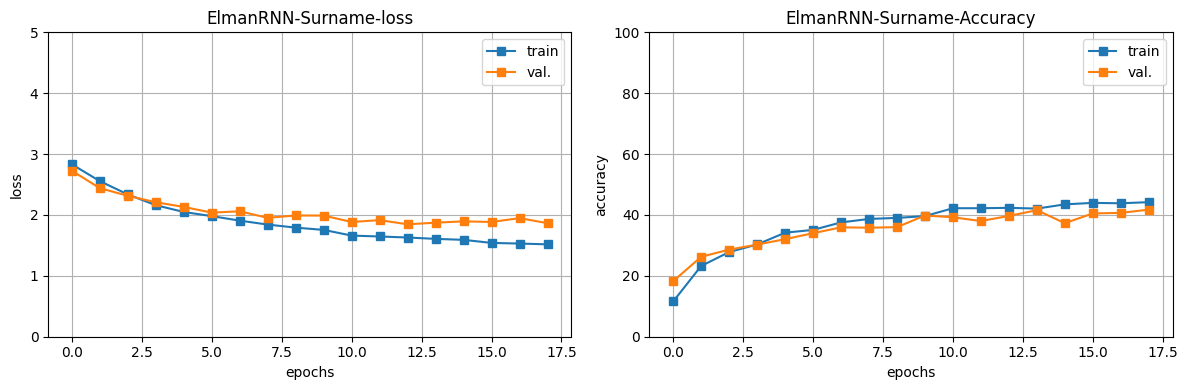

In [51]:
plt.figure(figsize=(12, 4))
plt.subplot(121)
plot(
    targets=(train_state["train_loss"], train_state["val_loss"]),
    labels = ["train", "val."],
    xlabel = "epochs",
    ylabel = "loss",
    ylim =[0, 5],
    grid = True,
    title = "ElmanRNN-Surname-loss",
    legend=True,
    markers="s"
    )
plt.subplot(122)
plot(
    targets=(train_state["train_acc"], train_state["val_acc"]),
    labels = ["train", "val."],
    xlabel = "epochs",
    ylabel = "accuracy",
    grid = True,
    ylim=[0,100],
    title = "ElmanRNN-Surname-Accuracy",
    legend=True,
    markers="s"
    )
plt.tight_layout()
plt.show()